# Imports and API configuration

In [1]:
import praw
import requests
import pandas as pd
import json
from tqdm import tqdm
from datetime import datetime
import os, datetime as dt
import re
import operator

In [2]:
with open("../redditCredentials.json", "r") as f:
    credentials = json.load(f)

In [3]:
reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='AITA-analysis',
                     username=credentials['USERNAME'],
                     check_for_async=False)

# Gathering top submissions

## A-HOLE

In [9]:
submissions_data = []
limit = 250
query = 'flair:"Asshole"' 
subreddit = reddit.subreddit("AmItheAsshole")

accepted = 0 

for submission in subreddit.search(query, sort="top", time_filter="all", limit=None):

    flair = (submission.link_flair_text or '').lower().strip()
    if not flair.startswith('asshole'):  
        continue

    accepted += 1
    if accepted > limit:
        break

    if accepted % 30 == 0:
        print(f"{accepted}/{limit} iterations")

    submission_data = {
        'author': getattr(submission, 'author', None),
        'author_flair_text': getattr(submission, 'author_flair_text', None),
        'clicked': submission.clicked,
        'comments': submission.comments,
        'created_utc': submission.created_utc,
        'created_time': datetime.fromtimestamp(submission.created_utc),
        'distinguished': submission.distinguished,
        'edited': submission.edited,
        'id': submission.id,
        'is_original_content': submission.is_original_content,
        'is_self': submission.is_self,
        'link_flair_template_id': getattr(submission, 'link_flair_template_id', None),
        'link_flair_text': getattr(submission, 'link_flair_text', None),
        'locked': submission.locked,
        'name': submission.name,
        'num_comments': submission.num_comments,
        'over_18': submission.over_18,
        'permalink': submission.permalink,
        'poll_data': getattr(submission, 'poll_data', None),
        'saved': submission.saved,
        'score': submission.score,
        'selftext': getattr(submission, 'selftext', None),
        'text': (submission.title or '') + (submission.selftext or ''),
        'spoiler': submission.spoiler,
        'stickied': submission.stickied,
        'subreddit': str(submission.subreddit),
        'title': submission.title,
        'upvote_ratio': submission.upvote_ratio,
        'url': submission.url
    }

    submissions_data.append(submission_data)


30/250 iterations
60/250 iterations
90/250 iterations
120/250 iterations
150/250 iterations
180/250 iterations
210/250 iterations


In [10]:
df = pd.DataFrame(submissions_data)
df.head()

,author,author_flair_text,clicked,comments,created_utc,created_time,distinguished,edited,id,is_original_content,...,saved,score,selftext,text,spoiler,stickied,subreddit,title,upvote_ratio,url
0,aljsdhnrthrow,None,False,"(etxbdfr, etx68zk, etx8185, etx5bcp, etxfk5p, ...",1.563292e+09,2019-07-16 17:41:11,None,False,cdypge,False,...,False,41140,\nThrowaway because husband told me I was TA a...,AITA for telling cashier that wasn’t the girls...,False,False,AmItheAsshole,AITA for telling cashier that wasn’t the girls...,0.80,https://www.reddit.com/r/AmItheAsshole/comment...
1,Resident_Occasion,None,False,"(ept96rx, ept96r0, ept9d6l, ept9b3v, ept92sj, ...",1.559485e+09,2019-06-02 16:10:33,None,1559509325.0,bvxqh8,False,...,False,40294,I'm the VP of Sales at a software company and ...,AITA For Firing An Employee After His Parents ...,False,False,AmItheAsshole,AITA For Firing An Employee After His Parents ...,0.81,https://www.reddit.com/r/AmItheAsshole/comment...
2,stupidtest_,None,False,"(em2qfbb, em3wltp, em2rt45, em2iu7e, ensztri, ...",1.556556e+09,2019-04-29 18:35:09,None,1556583602.0,birkjn,False,...,False,38270,My wife is pregnant with our daughter. Initial...,WIBTA if I ask my pregnant wife to move out be...,False,False,AmItheAsshole,WIBTA if I ask my pregnant wife to move out be...,0.93,https://www.reddit.com/r/AmItheAsshole/comment...
3,chancecreator,None,False,"(ftkwtow, ftkwdzs, ftkwv2h, ftkx0pa, ftkwgac, ...",1.591793e+09,2020-06-10 14:42:51,None,1591807453.0,h0a45w,False,...,False,37655,I have been living with my new wife and stepda...,AITA for telling my stepdaughter to stop using...,False,False,AmItheAsshole,AITA for telling my stepdaughter to stop using...,0.89,https://www.reddit.com/r/AmItheAsshole/comment...
4,ThrowRAhusband2,None,False,"(j2wz0pb, j2wcv0r, j2wcd9v, j2wczu3, j2wbizm, ...",1.672833e+09,2023-01-04 12:45:15,None,False,1031mvi,False,...,False,37402,"\nI've been married to my 2nd Husband ""Mike"" f...",AITA for telling my parents that they ruined N...,False,False,AmItheAsshole,AITA for telling my parents that they ruined N...,0.70,https://www.reddit.com/r/AmItheAsshole/comment...


In [11]:
df["link_flair_text"].value_counts()

link_flair_text
Asshole    229
Name: count, dtype: int64

In [ ]:
# df.to_csv('top250AITA-a_hole.csv', index=False)

## NOT A-HOLE

In [13]:
"""
Collect up to 250 r/AmItheAsshole submissions whose flair starts with
'Not the A-hole' (case-insensitive), including variants such as
'Not the A-hole POO Mode'.
"""

from datetime import datetime
import pandas as pd      # optional, only if you later build a DataFrame

submissions_data = []
limit = 250
query = 'flair:"Not the A-hole"'       # substring search covers all variants
subreddit = reddit.subreddit("AmItheAsshole")

accepted = 0                           # counts only the posts we keep

for submission in subreddit.search(query, sort="top", time_filter="all", limit=None):

    flair = (submission.link_flair_text or '').lower().strip()
    if not flair.startswith('not the a-hole'):   # skip other flairs
        continue

    accepted += 1
    if accepted > limit:
        break

    if accepted % 30 == 0:
        print(f"{accepted}/{limit} iterations")

    submission_data = {
        'author': getattr(submission, 'author', None),
        'author_flair_text': getattr(submission, 'author_flair_text', None),
        'clicked': submission.clicked,
        'comments': submission.comments,
        'created_utc': submission.created_utc,
        'created_time': datetime.fromtimestamp(submission.created_utc),
        'distinguished': submission.distinguished,
        'edited': submission.edited,
        'id': submission.id,
        'is_original_content': submission.is_original_content,
        'is_self': submission.is_self,
        'link_flair_template_id': getattr(submission, 'link_flair_template_id', None),
        'link_flair_text': getattr(submission, 'link_flair_text', None),
        'locked': submission.locked,
        'name': submission.name,
        'num_comments': submission.num_comments,
        'over_18': submission.over_18,
        'permalink': submission.permalink,
        'poll_data': getattr(submission, 'poll_data', None),
        'saved': submission.saved,
        'score': submission.score,
        'selftext': getattr(submission, 'selftext', None),
        'text': (submission.title or '') + (submission.selftext or ''),
        'spoiler': submission.spoiler,
        'stickied': submission.stickied,
        'subreddit': str(submission.subreddit),
        'title': submission.title,
        'upvote_ratio': submission.upvote_ratio,
        'url': submission.url
    }

    submissions_data.append(submission_data)

30/250 iterations
60/250 iterations
90/250 iterations
120/250 iterations
150/250 iterations
180/250 iterations
210/250 iterations


In [ ]:
# df = pd.DataFrame(submissions_data)
# df.to_csv('top250AITA-not_a_hole.csv', index=False)

# Data Preprocessing

In [4]:
df_not_a_hole = pd.read_csv("top250AITA-not_a_hole.csv")
df_a_hole = pd.read_csv("top250AITA-a_hole.csv")

## Downsampling for a balanced time and flair distribution

### removing 2024 and 2018 due to the low amount of samples

In [5]:
df_not_a_hole.created_time.apply(lambda x:x[:4]).value_counts()

created_time
2022    62
2020    58
2019    44
2021    39
2023    30
2024     1
2018     1
Name: count, dtype: int64

In [6]:
df_a_hole.created_time.apply(lambda x:x[:4]).value_counts()

created_time
2019    73
2022    67
2023    38
2020    29
2021    20
2024     1
2018     1
Name: count, dtype: int64

In [7]:
df_not_a_hole = df_not_a_hole[~df_not_a_hole['created_time'].str.startswith(('2024', '2018'))]
df_a_hole = df_a_hole[~df_a_hole['created_time'].str.startswith(('2024', '2018'))]
df_a_hole.created_time.apply(lambda x:x[:4]).value_counts()
print(len(df_a_hole), len(df_not_a_hole))

227 233


### removing lowest comments samples to have balanced flairs

In [11]:
m = 225

df_a_hole = df_a_hole.sort_values('num_comments', ascending=False).head(m).sort_values('created_time')
df_not_a_hole = df_not_a_hole.sort_values('num_comments', ascending=False).head(m).sort_values('created_time')

print(m, len(df_a_hole), len(df_not_a_hole))

225 225 225


## Visualizing comment distribution

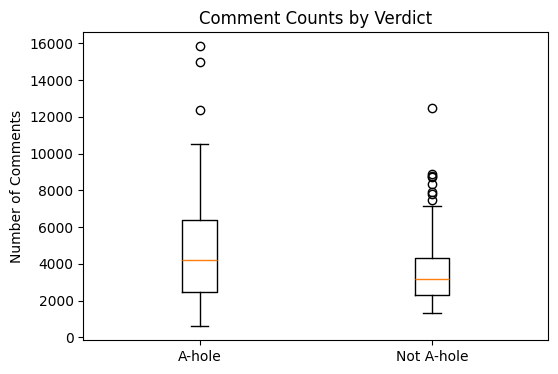

In [20]:
import matplotlib.pyplot as plt

data = [df_a_hole.num_comments, df_not_a_hole.num_comments]
labels = ['A-hole', 'Not A-hole']

plt.figure(figsize=(6,4))
plt.boxplot(data, tick_labels = labels)
plt.ylabel('Number of Comments')
plt.title('Comment Counts by Verdict')
plt.show()


## Concatenating the two df

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Concatenate the two DataFrames
df = pd.concat([df_a_hole, df_not_a_hole], ignore_index=True)

# 2. Make sure created_time is datetime, then pull out the year
df['created_time'] = pd.to_datetime(df['created_time'])      # if it isn’t already
df['year'] = df['created_time'].dt.year                      # same as .astype(str).str[:4]

In [27]:
df["link_flair_text"].value_counts()

link_flair_text
Asshole           225
Not the A-hole    225
Name: count, dtype: int64

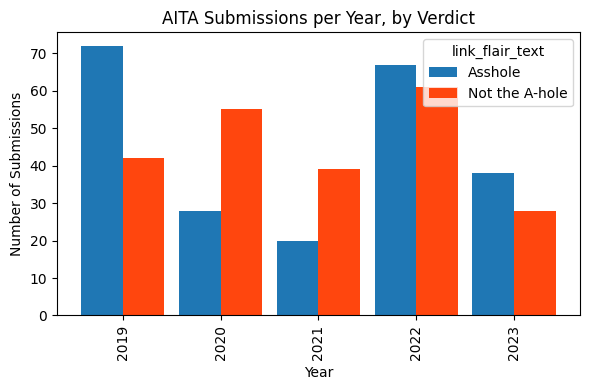

In [30]:
# keep the grouping code exactly as before …
year_flair_counts = (
    df.groupby(['year', 'link_flair_text'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

# make sure the columns are in the order you want
year_flair_counts = year_flair_counts[['Asshole', 'Not the A-hole']]

ax = year_flair_counts.plot(
    kind='bar',
    figsize=(6, 4),
    color=['#1f77b4', "#ff460e"],   # ← force blue & orange
    width=0.85
)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Submissions')
ax.set_title('AITA Submissions per Year, by Verdict')
ax.legend(title='link_flair_text')
plt.tight_layout()
plt.show()


In [31]:
df.to_csv('top450-aita-balanced.csv', index=False)